# MCS-Based Child Downselection Experiment

This notebook explores using Maximum Common Substructure (MCS) similarity as a potential child downselection strategy for DORAnet MCTS.

## Workflow
1. Run a single DORAnet expansion (enzymatic or synthetic mode)
2. Screen resulting metabolites against the PKS_SMILES.txt database (~13K entries)
3. Assign each metabolite its highest MCS score vs the PKS database
4. Select top N metabolites by MCS score
5. Report detailed timing metrics

## Key Question
Can we use MCS similarity to the PKS library as a heuristic for selecting which fragments to expand further? This could guide the search toward PKS-synthesizable chemical space.

---
## Cell 1: Imports and Setup

In [ ]:
import sys
import time
from pathlib import Path
from typing import List, Tuple, Optional

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdFMCS, Draw, Descriptors, AllChem, DataStructs
from rdkit.Chem.AtomPairs import Pairs  # For atom pair fingerprints
from rdkit import RDLogger
from IPython.display import display, HTML
from tqdm.notebook import tqdm  # Progress bar for Jupyter

# Silence RDKit warnings for cleaner output
RDLogger.DisableLog("rdApp.*")

# Add the repository root to the path
REPO_ROOT = Path.cwd().parent
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

# Project imports
from DORAnet_agent import DORAnetMCTS, Node
from DORAnet_agent.policies.rollout import _calculate_mcs_similarity_without_stereo

print(f"Repository root: {REPO_ROOT}")
print("Setup complete!")

---
## Cell 2: Load PKS Database

Load the PKS SMILES database and convert to RDKit Mol objects. We also pre-compute atom counts for efficient filtering.

In [ ]:
# Path to PKS database
PKS_DATABASE_PATH = REPO_ROOT / "data" / "processed" / "PKS_smiles.txt"

print(f"Loading PKS database from: {PKS_DATABASE_PATH}")
load_start = time.time()

# Load SMILES and convert to molecules + fingerprints
pks_smiles_list = []
pks_mols_with_atoms: List[Tuple[Chem.Mol, int, str]] = []  # (mol, atom_count, smiles)
pks_morgan_fps: List[Tuple[DataStructs.ExplicitBitVect, str]] = []  # Morgan fingerprints
pks_atompair_fps: List[Tuple[DataStructs.IntSparseIntVect, str]] = []  # Atom pair fingerprints
invalid_count = 0

with open(PKS_DATABASE_PATH, 'r') as f:
    for line in f:
        smiles = line.strip()
        if not smiles:
            continue
        pks_smiles_list.append(smiles)
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            atom_count = mol.GetNumAtoms()
            pks_mols_with_atoms.append((mol, atom_count, smiles))
            # Compute Morgan fingerprint (circular, radius=2)
            morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
            pks_morgan_fps.append((morgan_fp, smiles))
            # Compute Atom Pair fingerprint
            ap_fp = Pairs.GetAtomPairFingerprint(mol)
            pks_atompair_fps.append((ap_fp, smiles))
        else:
            invalid_count += 1

load_time = time.time() - load_start

print(f"\nPKS Database Statistics:")
print(f"  Total SMILES loaded: {len(pks_smiles_list):,}")
print(f"  Valid molecules: {len(pks_mols_with_atoms):,}")
print(f"  Morgan fingerprints: {len(pks_morgan_fps):,}")
print(f"  Atom pair fingerprints: {len(pks_atompair_fps):,}")
print(f"  Invalid SMILES (skipped): {invalid_count}")
print(f"  Loading time: {load_time:.2f} seconds")

# Show atom count distribution
atom_counts = [atoms for _, atoms, _ in pks_mols_with_atoms]
print(f"\nAtom count distribution:")
print(f"  Min: {min(atom_counts)}")
print(f"  Max: {max(atom_counts)}")
print(f"  Mean: {np.mean(atom_counts):.1f}")
print(f"  Median: {np.median(atom_counts):.1f}")

---
## Cell 3: Define MCS Screening Function

This function screens a query molecule against the PKS database with atom count pre-filtering to improve performance.

In [ ]:
def screen_against_pks_database_mcs(
    query_mol: Chem.Mol,
    pks_mols_with_atoms: List[Tuple[Chem.Mol, int, str]],
    timeout_per_comparison: float = 0.1,
    atom_count_tolerance: float = 0.5,  # +/-50% pre-filtering
) -> Tuple[float, int, str, float, int, int]:
    """
    Screen using MCS (Maximum Common Substructure) similarity.
    Includes atom count pre-filtering for performance.
    
    Returns: (best_score, best_idx, best_smiles, total_time, num_compared, num_timeouts)
    """
    start_time = time.time()
    
    query_atoms = query_mol.GetNumAtoms()
    min_atoms = int(query_atoms * (1 - atom_count_tolerance))
    max_atoms = int(query_atoms * (1 + atom_count_tolerance))
    
    filtered_pks = [
        (i, mol, atoms, smi) 
        for i, (mol, atoms, smi) in enumerate(pks_mols_with_atoms)
        if min_atoms <= atoms <= max_atoms
    ]
    
    best_score = 0.0
    best_idx = -1
    best_smiles = ""
    num_timeouts = 0
    
    for orig_idx, pks_mol, pks_atoms, pks_smi in filtered_pks:
        score = _calculate_mcs_similarity_without_stereo(
            query_mol, pks_mol, timeout=timeout_per_comparison
        )
        
        if score is None:
            num_timeouts += 1
            continue
            
        if score > best_score:
            best_score = score
            best_idx = orig_idx
            best_smiles = pks_smi
            if score >= 0.999:
                break
    
    total_time = time.time() - start_time
    return best_score, best_idx, best_smiles, total_time, len(filtered_pks), num_timeouts


def screen_against_pks_database_morgan(
    query_mol: Chem.Mol,
    pks_morgan_fps: List[Tuple[DataStructs.ExplicitBitVect, str]],
) -> Tuple[float, int, str, float, int]:
    """
    Screen using Morgan (circular) fingerprints with Tanimoto similarity.
    
    Returns: (best_score, best_idx, best_smiles, total_time, num_compared)
    """
    start_time = time.time()
    
    query_fp = AllChem.GetMorganFingerprintAsBitVect(query_mol, radius=2, nBits=2048)
    
    best_score = 0.0
    best_idx = -1
    best_smiles = ""
    
    for i, (pks_fp, pks_smi) in enumerate(pks_morgan_fps):
        score = DataStructs.TanimotoSimilarity(query_fp, pks_fp)
        if score > best_score:
            best_score = score
            best_idx = i
            best_smiles = pks_smi
    
    total_time = time.time() - start_time
    return best_score, best_idx, best_smiles, total_time, len(pks_morgan_fps)


def screen_against_pks_database_atompair(
    query_mol: Chem.Mol,
    pks_atompair_fps: List[Tuple[DataStructs.IntSparseIntVect, str]],
) -> Tuple[float, int, str, float, int]:
    """
    Screen using Atom Pair fingerprints with Dice similarity.
    
    Atom pair fingerprints encode pairs of atoms and the topological 
    distance between them, capturing different structural features 
    than circular fingerprints.
    
    Returns: (best_score, best_idx, best_smiles, total_time, num_compared)
    """
    start_time = time.time()
    
    query_fp = Pairs.GetAtomPairFingerprint(query_mol)
    
    best_score = 0.0
    best_idx = -1
    best_smiles = ""
    
    for i, (pks_fp, pks_smi) in enumerate(pks_atompair_fps):
        score = DataStructs.DiceSimilarity(query_fp, pks_fp)
        if score > best_score:
            best_score = score
            best_idx = i
            best_smiles = pks_smi
    
    total_time = time.time() - start_time
    return best_score, best_idx, best_smiles, total_time, len(pks_atompair_fps)


# Test all three functions
print("Testing screening functions...")
test_mol = Chem.MolFromSmiles("CCCCCCCCC(=O)O")  # Nonanoic acid
print(f"Test molecule: nonanoic acid (CCCCCCCCC(=O)O)")
print(f"  Atom count: {test_mol.GetNumAtoms()}")

print("\n--- MCS Similarity ---")
score, idx, match_smi, t, n_compared, n_timeouts = screen_against_pks_database_mcs(
    test_mol, pks_mols_with_atoms, timeout_per_comparison=0.1
)
print(f"  Best score: {score:.4f}, Time: {t*1000:.2f} ms, Comparisons: {n_compared:,}")

print("\n--- Morgan Fingerprint (Tanimoto) ---")
score, idx, match_smi, t, n_compared = screen_against_pks_database_morgan(
    test_mol, pks_morgan_fps
)
print(f"  Best score: {score:.4f}, Time: {t*1000:.2f} ms, Comparisons: {n_compared:,}")

print("\n--- Atom Pair Fingerprint (Dice) ---")
score, idx, match_smi, t, n_compared = screen_against_pks_database_atompair(
    test_mol, pks_atompair_fps
)
print(f"  Best score: {score:.4f}, Time: {t*1000:.2f} ms, Comparisons: {n_compared:,}")

---
## Cell 4: Configure and Run DORAnet Expansion

Configure the target molecule and expansion mode, then run a single DORAnet expansion.

Target molecule: salicylic_acid
SMILES: O=C(O)c1ccccc1O

Expansion mode:
  Enzymatic: True
  Synthetic: True

Target properties:
  Atom count: 10
  Molecular weight: 138.1


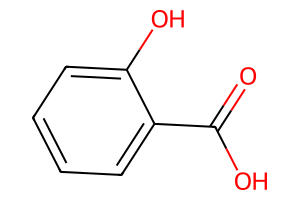

In [4]:
# ============================================================================
# CONFIGURATION - Modify these parameters as needed
# ============================================================================

# Target molecule
TARGET_SMILES = "O=C(O)c1ccccc1O"  # Salicylic acid
TARGET_NAME = "salicylic_acid"

# Alternative targets (uncomment to use):
# TARGET_SMILES = "COC1=CC(OC(CCC2=CC3=C(OCO3)C=C2)C1)=O"  # 7,8-dihydromethysticin
# TARGET_NAME = "7,8-dihydromethysticin"

# TARGET_SMILES = "CCCCCCCCC(=O)O"  # Nonanoic acid (known PKS product)
# TARGET_NAME = "nonanoic_acid"

# Expansion mode configuration
USE_ENZYMATIC = True   # Use enzymatic transformations
USE_SYNTHETIC = True   # Use synthetic transformations

# ============================================================================

print(f"Target molecule: {TARGET_NAME}")
print(f"SMILES: {TARGET_SMILES}")
print(f"\nExpansion mode:")
print(f"  Enzymatic: {USE_ENZYMATIC}")
print(f"  Synthetic: {USE_SYNTHETIC}")

# Parse target molecule
target_molecule = Chem.MolFromSmiles(TARGET_SMILES)
if target_molecule is None:
    raise ValueError(f"Could not parse target SMILES: {TARGET_SMILES}")

target_atoms = target_molecule.GetNumAtoms()
target_mw = Descriptors.MolWt(target_molecule)
print(f"\nTarget properties:")
print(f"  Atom count: {target_atoms}")
print(f"  Molecular weight: {target_mw:.1f}")

# Display target
display(Draw.MolToImage(target_molecule, size=(300, 200)))

In [5]:
# Reset node counter for clean numbering
Node.node_counter = 0

# Create root node
root = Node(fragment=target_molecule, parent=None, depth=0, provenance="target")

# Paths to required data files
cofactors_files = [
    str(REPO_ROOT / "data" / "raw" / "all_cofactors.csv"),
    str(REPO_ROOT / "data" / "raw" / "chemistry_helpers.csv"),
]

# We don't need sink compounds for this experiment (we're just expanding)
# But we'll load minimal files to satisfy the agent initialization
sink_compounds_files = [
    str(REPO_ROOT / "data" / "processed" / "biological_building_blocks.txt"),
]

prohibited_chemicals_file = str(REPO_ROOT / "data" / "processed" / "prohibited_chemical_SMILES.txt")

print("Initializing DORAnet MCTS agent...")
init_start = time.time()

# Create DORAnet agent with minimal configuration for single expansion
agent = DORAnetMCTS(
    root=root,
    target_molecule=target_molecule,
    total_iterations=1,  # We only need 1 iteration for single expansion
    max_depth=1,
    use_enzymatic=USE_ENZYMATIC,
    use_synthetic=USE_SYNTHETIC,
    generations_per_expand=1,
    max_children_per_expand=1000,  # No limit - we want ALL fragments
    child_downselection_strategy="first_N",  # Fastest strategy
    cofactors_files=cofactors_files,
    sink_compounds_files=sink_compounds_files,
    prohibited_chemicals_file=prohibited_chemicals_file,
    MW_multiple_to_exclude=2.0,  # Allow larger fragments for this experiment
    spawn_retrotide=False,  # No RetroTide spawning
)

init_time = time.time() - init_start
print(f"Agent initialization time: {init_time:.2f} seconds")

# Run single expansion
print(f"\nRunning DORAnet expansion...")
expand_start = time.time()

# Expand the root node
children = agent.expand(root)

expand_time = time.time() - expand_start

print(f"\nExpansion Results:")
print(f"  Fragments generated: {len(children)}")
print(f"  Expansion time: {expand_time:.2f} seconds")

# Count by provenance
enzymatic_count = sum(1 for c in children if c.provenance == "enzymatic")
synthetic_count = sum(1 for c in children if c.provenance == "synthetic")
print(f"\nBy provenance:")
print(f"  Enzymatic: {enzymatic_count}")
print(f"  Synthetic: {synthetic_count}")

Initializing DORAnet MCTS agent...
[DORAnet] Preprocessed target molecule:
[DORAnet]   Original SMILES: O=C(O)c1ccccc1O
[DORAnet]   Canonical SMILES (no stereo): O=C(O)c1ccccc1O
[DORAnet] Target MW: 138.12, Max fragment MW: 276.24 (excluding fragments > 2.0x target)
[DORAnet] Selection policy: depth_biased (coefficient=2.0) - favoring deeper exploration
[DORAnet] Child downselection: first_N (DORAnet order)
[DORAnet] Loaded 39 cofactors from all_cofactors.csv
[DORAnet] Loaded 21 cofactors from chemistry_helpers.csv
[DORAnet] Loaded 334 sink compounds from biological_building_blocks.txt
[DORAnet] Total sink compounds loaded: 334 (biological: 334, chemical: 0)
[DORAnet] Loaded 652 prohibited chemicals from prohibited_chemical_SMILES.txt


[DORAnet] Loaded 3604 enzymatic rule labels
[DORAnet] Loaded 386 synthetic reaction labels
[DORAnet] Using 21 chemistry helpers for synthetic network generation
[DORAnet] Using rollout policy: NoOp
[DORAnet] Using reward policy: SparseTerminal(sink_reward=1.0)
[DORAnet] DORA-XGB available for enzymatic feasibility scoring
[DORAnet] pathermo available for synthetic thermodynamic scoring
Agent initialization time: 0.14 seconds

Running DORAnet expansion...
Job name: doranet_enzymatic_retro_a2e9f28f
Job type: enzymatic network expansion retro
Job started on: 2026-01-26 14:26:07.599286


Number of generations: 1
Number of operators loaded: 3571
Number of molecules before expantion (including cofactors): 42
Number of molecules after expantion (including cofactors): 119
Number of reactions: 91
Time used for network generation: 0.35 minutes



Job name: doranet_synthetic_retro_462bc4f2
Job type: synthetic network expansion retro
Job started on: 2026-01-26 14:26:30.493619


Number of generations: 1
Number of operators: 384
Number of molecules before expantion: 22
Number of molecules after expantion: 143
Number of reactions: 148
Time used for network generation: 0.02 minutes



[DORAnet] Fragment O=C(O[C@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O)c1ccccc1O exceeds MW threshold (300.3 > 276.2) - skipping
[DORAnet] Fragment O=C(O)c1ccccc1O[C@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O exceeds MW threshold (300.3 > 276.2) - skipping
[DORAnet] Fragment CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)c1ccccc1O exceeds MW threshold (887.6 > 276.2) - skipping
[DORAnet] Fragment CC(=O)O is a BIOLOGICAL BUILDING BLOCK
[DORAnet] Fragment CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCO exceeds MW threshold (751.5 > 276.2) - skipping


[DORAnet] Fragment O=CO is a BIOLOGICAL BUILDING BLOCK
[DORAnet] Fragment O=C(O)c1c(O)cccc1C(O)(O)c1ccccc1O exceeds MW threshold (276.2 > 276.2) - skipping
[DORAnet] Fragment O=C(O)c1cc(C(O)(O)c2ccccc2O)ccc1O exceeds MW threshold (276.2 > 276.2) - skipping
[DORAnet] Fragment O=C(O)c1ccc(C(O)(O)c2ccccc2O)cc1O exceeds MW threshold (276.2 > 276.2) - skipping
[DORAnet] Fragment O=C(O)c1cccc(C(O)(O)c2ccccc2O)c1O exceeds MW threshold (276.2 > 276.2) - skipping
[DORAnet] Fragment Nc1ccccc1C(=O)O is a BIOLOGICAL BUILDING BLOCK


[DORAnet] Fragment Oc1ccccc1C(O)(O)C(O)(O)c1ccccc1O exceeds MW threshold (278.3 > 276.2) - skipping
[DORAnet] Fragment O=C(O)c1c(O)cccc1Sc1cccc(O)c1C(=O)O exceeds MW threshold (306.3 > 276.2) - skipping
[DORAnet] Fragment O=C(O)c1cc(Sc2cccc(O)c2C(=O)O)ccc1O exceeds MW threshold (306.3 > 276.2) - skipping
[DORAnet] Fragment O=C(O)c1ccc(Sc2cccc(O)c2C(=O)O)cc1O exceeds MW threshold (306.3 > 276.2) - skipping
[DORAnet] Fragment O=C(O)c1cccc(Sc2cccc(O)c2C(=O)O)c1O exceeds MW threshold (306.3 > 276.2) - skipping
[DORAnet] Fragment O=C(O)c1cc(Sc2ccc(O)c(C(=O)O)c2)ccc1O exceeds MW threshold (306.3 > 276.2) - skipping
[DORAnet] Fragment O=C(O)c1ccc(Sc2ccc(O)c(C(=O)O)c2)cc1O exceeds MW threshold (306.3 > 276.2) - skipping
[DORAnet] Fragment O=C(O)c1cc(Sc2cccc(C(=O)O)c2O)ccc1O exceeds MW threshold (306.3 > 276.2) - skipping
[DORAnet] Fragment O=C(O)c1ccc(Sc2ccc(C(=O)O)c(O)c2)cc1O exceeds MW threshold (306.3 > 276.2) - skipping
[DORAnet] Fragment O=C(O)c1ccc(Sc2cccc(C(=O)O)c2O)cc1O exceeds MW thre

---
## Cell 5: Screen All Fragments Against PKS Database

For each fragment from the expansion, compute MCS similarity against all PKS molecules.

In [ ]:
# ============================================================================
# SCREENING CONFIGURATION
# ============================================================================
SIMILARITY_METHOD = "morgan"  # Options: "mcs", "morgan", or "atompair"
MCS_TIMEOUT = 0.1  # Timeout per MCS comparison (only used if method is "mcs")
# ============================================================================

method_descriptions = {
    "mcs": "MCS (Maximum Common Substructure)",
    "morgan": "Morgan Fingerprint (Tanimoto similarity)", 
    "atompair": "Atom Pair Fingerprint (Dice similarity)",
}

print(f"Screening {len(children)} fragments against PKS database...")
print(f"PKS database size: {len(pks_mols_with_atoms):,} molecules")
print(f"Similarity method: {method_descriptions.get(SIMILARITY_METHOD, SIMILARITY_METHOD)}")
print()

screening_start = time.time()
results = []

for child in tqdm(children, desc="Screening fragments", unit="fragment"):
    if child.fragment is None:
        continue
    
    if SIMILARITY_METHOD == "mcs":
        score, idx, match_smi, t, n_compared, n_timeouts = screen_against_pks_database_mcs(
            child.fragment, 
            pks_mols_with_atoms,
            timeout_per_comparison=MCS_TIMEOUT,
            atom_count_tolerance=0.5,
        )
    elif SIMILARITY_METHOD == "morgan":
        score, idx, match_smi, t, n_compared = screen_against_pks_database_morgan(
            child.fragment,
            pks_morgan_fps,
        )
        n_timeouts = 0
    elif SIMILARITY_METHOD == "atompair":
        score, idx, match_smi, t, n_compared = screen_against_pks_database_atompair(
            child.fragment,
            pks_atompair_fps,
        )
        n_timeouts = 0
    else:
        raise ValueError(f"Unknown similarity method: {SIMILARITY_METHOD}")
    
    results.append({
        'node_id': child.node_id,
        'smiles': child.smiles,
        'provenance': child.provenance,
        'reaction_name': child.reaction_name,
        'atom_count': child.fragment.GetNumAtoms(),
        'similarity_score': score,
        'best_pks_match': match_smi,
        'screening_time': t,
        'comparisons_made': n_compared,
        'timeouts': n_timeouts,
    })

total_screening_time = time.time() - screening_start

# Convert to DataFrame
df = pd.DataFrame(results)

print(f"\nScreening complete!")
print(f"  Method: {method_descriptions.get(SIMILARITY_METHOD, SIMILARITY_METHOD)}")
print(f"  Total screening time: {total_screening_time:.2f} seconds")
print(f"  Average time per fragment: {total_screening_time / len(results) * 1000:.2f} ms")

---
## Cell 6: Rank and Select Top N

Sort fragments by MCS score and display the top candidates.

In [7]:
# Configuration
TOP_N = 10  # Number of top fragments to display

# Sort by similarity score (descending)
df_sorted = df.sort_values('similarity_score', ascending=False).reset_index(drop=True)

print(f"Top {TOP_N} Fragments by {SIMILARITY_METHOD.upper()} Similarity to PKS Database")
print("=" * 80)

# Display top N
for i, row in df_sorted.head(TOP_N).iterrows():
    print(f"\nRank {i+1}:")
    print(f"  SMILES: {row['smiles']}")
    print(f"  {SIMILARITY_METHOD.upper()} Score: {row['similarity_score']:.4f}")
    print(f"  Best PKS Match: {row['best_pks_match']}")
    print(f"  Provenance: {row['provenance']}")
    print(f"  Reaction: {row['reaction_name']}")
    print(f"  Atom Count: {row['atom_count']}")

# Show score statistics
print("\n" + "=" * 80)
print(f"\n{SIMILARITY_METHOD.upper()} Score Statistics:")
print(f"  Max: {df['similarity_score'].max():.4f}")
print(f"  Min: {df['similarity_score'].min():.4f}")
print(f"  Mean: {df['similarity_score'].mean():.4f}")
print(f"  Median: {df['similarity_score'].median():.4f}")
print(f"  Std: {df['similarity_score'].std():.4f}")

# Count high-scoring fragments
high_score_thresholds = [0.9, 0.8, 0.7, 0.5]
print("\nFragments above thresholds:")
for threshold in high_score_thresholds:
    count = (df['similarity_score'] >= threshold).sum()
    pct = 100 * count / len(df)
    print(f"  Score >= {threshold}: {count} ({pct:.1f}%)")

Top 10 Fragments by TANIMOTO Similarity to PKS Database

Rank 1:
  SMILES: O=C(O)C=CC=CC(=O)C(=O)O
  TANIMOTO Score: 0.5000
  Best PKS Match: CC=CC=CC=CC(=O)O
  Provenance: enzymatic
  Reaction: rule0050_19
  Atom Count: 12

Rank 2:
  SMILES: O=C(O)c1ccccc1
  TANIMOTO Score: 0.4231
  Best PKS Match: O=C(O)CCCCCC(=O)c1ccccc1
  Provenance: enzymatic
  Reaction: rule0005_51
  Atom Count: 9

Rank 3:
  SMILES: CC(C)=CCc1ccc(C(=O)O)c(O)c1
  TANIMOTO Score: 0.3696
  Best PKS Match: CC(C=CC(=O)C(C)C(=O)O)=CCc1ccccc1
  Provenance: enzymatic
  Reaction: rule0101_3
  Atom Count: 15

Rank 4:
  SMILES: CC(C)=CCc1ccc(O)c(C(=O)O)c1
  TANIMOTO Score: 0.3556
  Best PKS Match: CC(=CCc1ccccc1)C(=O)CC=CC(=O)O
  Provenance: enzymatic
  Reaction: rule0101_3
  Atom Count: 15

Rank 5:
  SMILES: Nc1ccc(C(=O)O)c(O)c1
  TANIMOTO Score: 0.3333
  Best PKS Match: Nc1ccc(C(=O)CC(=O)CC(=O)CC(=O)O)cc1
  Provenance: synthetic
  Reaction: Tiffeneau–Demjanov Rearrangement
  Atom Count: 11

Rank 6:
  SMILES: CC(C)=CCOc1cc


Top 6 Fragments (by TANIMOTO score):


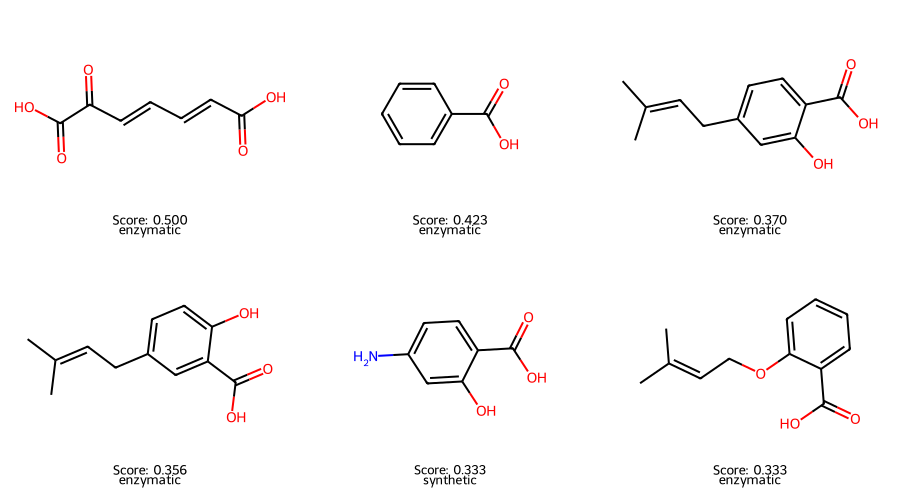

In [8]:
# Visualize top fragments
print(f"\nTop {min(TOP_N, 6)} Fragments (by {SIMILARITY_METHOD.upper()} score):")

top_mols = []
top_legends = []

for i, row in df_sorted.head(min(TOP_N, 6)).iterrows():
    mol = Chem.MolFromSmiles(row['smiles'])
    if mol:
        top_mols.append(mol)
        top_legends.append(f"Score: {row['similarity_score']:.3f}\n{row['provenance']}")

if top_mols:
    img = Draw.MolsToGridImage(
        top_mols, 
        molsPerRow=3, 
        subImgSize=(300, 250),
        legends=top_legends
    )
    display(img)

---
## Cell 7: Timing Summary

Detailed breakdown of computational costs.

In [9]:
print("=" * 60)
print("TIMING SUMMARY")
print("=" * 60)

print(f"\n1. PKS Database Loading")
print(f"   Time: {load_time:.2f} seconds")
print(f"   Molecules loaded: {len(pks_mols_with_atoms):,}")
print(f"   Fingerprints computed: {len(pks_fingerprints):,}")

print(f"\n2. DORAnet Agent Initialization")
print(f"   Time: {init_time:.2f} seconds")

print(f"\n3. DORAnet Expansion")
print(f"   Time: {expand_time:.2f} seconds")
print(f"   Fragments generated: {len(children)}")
print(f"   Time per fragment: {expand_time / max(len(children), 1):.4f} seconds")

print(f"\n4. Similarity Screening ({SIMILARITY_METHOD.upper()})")
print(f"   Total time: {total_screening_time:.2f} seconds")
print(f"   Fragments screened: {len(results)}")
print(f"   Average time per fragment: {df['screening_time'].mean()*1000:.2f} ms")
print(f"   Min time per fragment: {df['screening_time'].min()*1000:.2f} ms")
print(f"   Max time per fragment: {df['screening_time'].max()*1000:.2f} ms")

# Comparison statistics
print(f"\n   Comparisons per fragment:")
print(f"     Mean: {df['comparisons_made'].mean():.0f}")
print(f"     Min: {df['comparisons_made'].min()}")
print(f"     Max: {df['comparisons_made'].max()}")

total_timeouts = df['timeouts'].sum()
total_comparisons = df['comparisons_made'].sum()
print(f"\n   Total comparisons made: {total_comparisons:,}")
if SIMILARITY_METHOD == "mcs":
    print(f"   Total timeouts: {total_timeouts}")
    if total_comparisons > 0:
        print(f"   Timeout rate: {100 * total_timeouts / total_comparisons:.2f}%")

# Total time
total_time = load_time + init_time + expand_time + total_screening_time
print(f"\n" + "=" * 60)
print(f"TOTAL TIME: {total_time:.2f} seconds ({total_time/60:.1f} minutes)")
print("=" * 60)

# Extrapolations
print(f"\nExtrapolated times for {SIMILARITY_METHOD.upper()} (assuming linear scaling):")
avg_screen_time = df['screening_time'].mean()
for n_fragments in [50, 100, 500, 1000]:
    est_time = n_fragments * avg_screen_time
    print(f"  {n_fragments} fragments: {est_time:.1f} seconds ({est_time/60:.1f} minutes)")

TIMING SUMMARY

1. PKS Database Loading
   Time: 0.72 seconds
   Molecules loaded: 13,312
   Fingerprints computed: 13,312

2. DORAnet Agent Initialization
   Time: 0.14 seconds

3. DORAnet Expansion
   Time: 25.42 seconds
   Fragments generated: 178
   Time per fragment: 0.1428 seconds

4. Similarity Screening (TANIMOTO)
   Total time: 3.98 seconds
   Fragments screened: 178
   Average time per fragment: 22.11 ms
   Min time per fragment: 19.58 ms
   Max time per fragment: 74.58 ms

   Comparisons per fragment:
     Mean: 13312
     Min: 13312
     Max: 13312

   Total comparisons made: 2,369,536

TOTAL TIME: 30.26 seconds (0.5 minutes)

Extrapolated times for TANIMOTO (assuming linear scaling):
  50 fragments: 1.1 seconds (0.0 minutes)
  100 fragments: 2.2 seconds (0.0 minutes)
  500 fragments: 11.1 seconds (0.2 minutes)
  1000 fragments: 22.1 seconds (0.4 minutes)


---
## Cell 8: Visualization

Histograms and charts to understand the MCS score distribution.

/var/folders/hs/xtwr8t4d32ld0_49rr9t_yq00000gn/T/ipykernel_3251/2018852961.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([enz_scores, syn_scores], labels=['Enzymatic', 'Synthetic'])


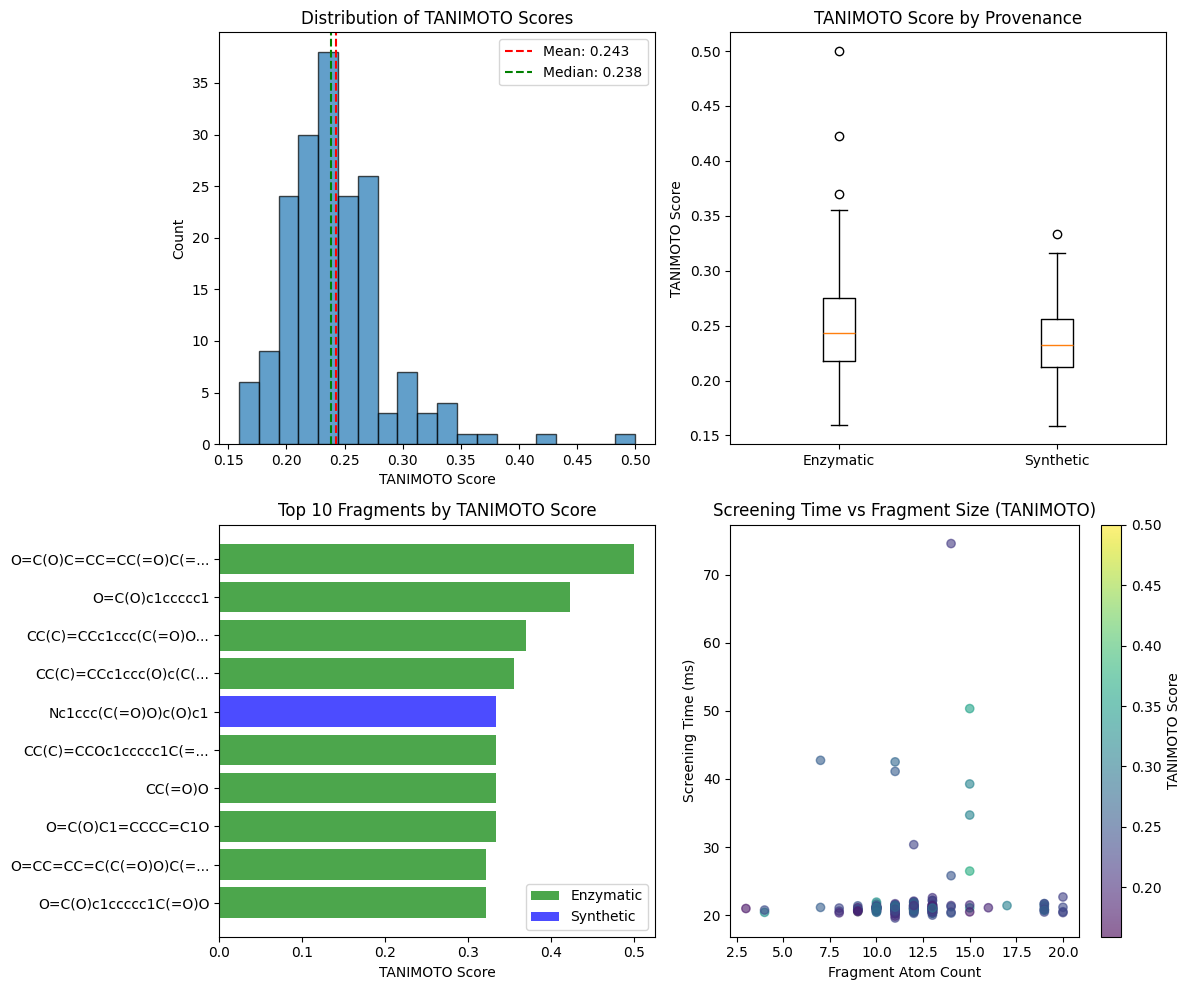

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Histogram of similarity scores
ax1 = axes[0, 0]
ax1.hist(df['similarity_score'], bins=20, edgecolor='black', alpha=0.7)
ax1.axvline(df['similarity_score'].mean(), color='red', linestyle='--', label=f"Mean: {df['similarity_score'].mean():.3f}")
ax1.axvline(df['similarity_score'].median(), color='green', linestyle='--', label=f"Median: {df['similarity_score'].median():.3f}")
ax1.set_xlabel(f'{SIMILARITY_METHOD.upper()} Score')
ax1.set_ylabel('Count')
ax1.set_title(f'Distribution of {SIMILARITY_METHOD.upper()} Scores')
ax1.legend()

# 2. Score by provenance
ax2 = axes[0, 1]
if 'enzymatic' in df['provenance'].values and 'synthetic' in df['provenance'].values:
    enz_scores = df[df['provenance'] == 'enzymatic']['similarity_score']
    syn_scores = df[df['provenance'] == 'synthetic']['similarity_score']
    ax2.boxplot([enz_scores, syn_scores], labels=['Enzymatic', 'Synthetic'])
    ax2.set_ylabel(f'{SIMILARITY_METHOD.upper()} Score')
    ax2.set_title(f'{SIMILARITY_METHOD.upper()} Score by Provenance')
else:
    ax2.text(0.5, 0.5, 'Single provenance type', ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title(f'{SIMILARITY_METHOD.upper()} Score by Provenance')

# 3. Top N fragments bar chart
ax3 = axes[1, 0]
top_df = df_sorted.head(TOP_N)
colors = ['green' if p == 'enzymatic' else 'blue' for p in top_df['provenance']]
bars = ax3.barh(range(len(top_df)), top_df['similarity_score'], color=colors, alpha=0.7)
ax3.set_yticks(range(len(top_df)))
ax3.set_yticklabels([f"{s[:20]}..." if len(s) > 20 else s for s in top_df['smiles']])
ax3.set_xlabel(f'{SIMILARITY_METHOD.upper()} Score')
ax3.set_title(f'Top {TOP_N} Fragments by {SIMILARITY_METHOD.upper()} Score')
ax3.invert_yaxis()
# Legend for provenance colors
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', alpha=0.7, label='Enzymatic'),
                   Patch(facecolor='blue', alpha=0.7, label='Synthetic')]
ax3.legend(handles=legend_elements, loc='lower right')

# 4. Screening time vs atom count
ax4 = axes[1, 1]
scatter = ax4.scatter(df['atom_count'], df['screening_time']*1000, 
                       c=df['similarity_score'], cmap='viridis', alpha=0.6)
ax4.set_xlabel('Fragment Atom Count')
ax4.set_ylabel('Screening Time (ms)')
ax4.set_title(f'Screening Time vs Fragment Size ({SIMILARITY_METHOD.upper()})')
plt.colorbar(scatter, ax=ax4, label=f'{SIMILARITY_METHOD.upper()} Score')

plt.tight_layout()
plt.show()

---
## Conclusions

### Key Findings

Based on this experiment, consider:

1. **MCS Score Distribution**: How many fragments have high PKS similarity?
2. **Computational Cost**: Is MCS screening fast enough for use during MCTS?
3. **Provenance Differences**: Do enzymatic or synthetic fragments have higher PKS similarity?
4. **Atom Count Effect**: Does fragment size correlate with screening time or MCS score?

### Potential Applications

- Use MCS score as a child downselection criterion (select top N by score)
- Use MCS score as a reward signal (guide search toward PKS-compatible space)
- Pre-filter fragments below a minimum MCS threshold

### Next Steps

1. Integrate MCS-based downselection into `DORAnetMCTS` as a new strategy
2. Compare MCTS performance with MCS downselection vs other strategies
3. Consider caching MCS scores for repeated fragments

In [11]:
# Optional: Export results to CSV
EXPORT_RESULTS = False  # Set to True to export

if EXPORT_RESULTS:
    output_path = REPO_ROOT / "results" / f"mcs_screening_{TARGET_NAME}.csv"
    df_sorted.to_csv(output_path, index=False)
    print(f"Results exported to: {output_path}")
else:
    print("Results not exported. Set EXPORT_RESULTS = True to export.")

Results not exported. Set EXPORT_RESULTS = True to export.
